In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.datasets.samples_generator import make_blobs 

import xml

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

### Importing Brussels municipalities data

In [3]:
file ='Brussels_municipalities.xlsx'
bxl = pd.read_excel(file)
bxl


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89


In [4]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


address = 'Bruxelles, BE'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print('The geograpical coordinate of Brussels are {}, {}.'.format(lat, long))


map_muni = folium.Map(location=[lat, long], zoom_start=12)

# add markers to the map


for lati, longi, Municipality  in zip(bxl['Latitude'], bxl['Longitude'], bxl['Municipality']):
    label = folium.Popup(Municipality, parse_html=True)
    folium.CircleMarker(
        [lati, longi],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color= '#3186cc',
        fill_opacity=0.7
        
).add_to(map_muni)  


map_muni


The geograpical coordinate of Brussels are 50.8465573, 4.351697.


### add columns for count of interest points

In [5]:
bxl['restaurants'] =''
bxl['schools'] =''
bxl['public_transport_station'] =''
bxl['shops'] =''
bxl['parks'] =''
bxl.head()

,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,,,,,
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,,,,,
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,,,,,
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,,,,,
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,,,,,


### assign color to municipalities

### foursquare credentials

In [6]:
CLIENT_ID = 'T0R3JUYI0XKHPTZ1TLMUOM1DB5PMGNYL4JJCUMERAHG30VRH' # your Foursquare ID
CLIENT_SECRET = '3O35W3AHHHOQ0HSMPRFAMM1WBW4WGIUA3PVLX5WHOXXYXVMC' # your Foursquare Secret
VERSION = '20190423'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T0R3JUYI0XKHPTZ1TLMUOM1DB5PMGNYL4JJCUMERAHG30VRH
CLIENT_SECRET:3O35W3AHHHOQ0HSMPRFAMM1WBW4WGIUA3PVLX5WHOXXYXVMC


In [7]:
for i in range(0,len(bxl)):
    
        search_query = 'restaurant'
        radius = 1000
        LATITUDE = bxl.Latitude[i]
        LONGITUDE = bxl.Longitude[i]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
#        bxl.search_query[j] = len(dataframe)
        bxl.restaurants[i] = len(dataframe)

bxl

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,,,,
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,,,,
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,,,,
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,,,,
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,,,,
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,,,,
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,,,,
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,,,,
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,,,,
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,,,,


In [9]:
for i in range(0,len(bxl)):
    
        search_query = 'écoles'
        radius = 2000
        LATITUDE = bxl.Latitude[i]
        LONGITUDE = bxl.Longitude[i]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
#        bxl.search_query[j] = len(dataframe)
        bxl.schools[i] = len(dataframe)

bxl

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,,,
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,,,
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,,,
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,,,
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,,,
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,7,,,
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,12,,,
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,6,,,
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,2,,,
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,3,,,


In [10]:
for i in range(0,len(bxl)):
    
        search_query = 'Station de métro'
        radius = 1000
        LATITUDE = bxl.Latitude[i]
        LONGITUDE = bxl.Longitude[i]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
#        bxl.search_query[j] = len(dataframe)
        bxl.public_transport_station[i] = len(dataframe)

bxl

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,18,,
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,7,,
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,8,,
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,8,,
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,2,,
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,7,9,,
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,12,7,,
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,6,6,,
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,2,1,,
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,3,0,,


In [11]:
for i in range(0,len(bxl)):
    
        search_query = 'shop'
        radius = 1000
        LATITUDE = bxl.Latitude[i]
        LONGITUDE = bxl.Longitude[i]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
#        bxl.search_query[j] = len(dataframe)
        bxl.shops[i] = len(dataframe)

bxl

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,18,30,
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,7,10,
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,8,30,
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,8,30,
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,2,28,
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,7,9,15,
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,12,7,30,
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,6,6,7,
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,2,1,8,
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,3,0,16,


In [12]:
for i in range(0,len(bxl)):
    
        search_query = 'parcs'
        radius = 2000
        LATITUDE = bxl.Latitude[i]
        LONGITUDE = bxl.Longitude[i]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
#        bxl.search_query[j] = len(dataframe)
        bxl.parks[i] = len(dataframe)

bxl

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,18,30,2
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,7,10,3
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,8,30,2
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,8,30,1
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,2,28,0
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,7,9,15,0
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,12,7,30,2
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,6,6,7,2
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,2,1,8,0
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,3,0,16,0


## study correlation of variables

### convert text fields to numeric

In [63]:
bxl.dtypes

PostalCode                    int64
Municipality                 object
Latitude                    float64
Longitude                   float64
size(km^2)                  float64
population                    int64
Population_density            int64
population_average_age      float64
restaurants                  object
schools                      object
public_transport_station     object
shops                        object
parks                        object
dtype: object

In [13]:
bxl[["restaurants"]] = bxl[["restaurants"]].astype("int")
bxl[["schools"]] = bxl[["schools"]].astype("int")
bxl[["public_transport_station"]] = bxl[["public_transport_station"]].astype("int")
bxl[["shops"]] = bxl[["shops"]].astype("int")
bxl[["parks"]] = bxl[["parks"]].astype("int")

In [14]:
bxl.dtypes

PostalCode                    int64
Municipality                 object
Latitude                    float64
Longitude                   float64
size(km^2)                  float64
population                    int64
Population_density            int64
population_average_age      float64
restaurants                   int64
schools                       int64
public_transport_station      int64
shops                         int64
parks                         int64
dtype: object

## correlation matrix of fields of interest

In [15]:
bxl[['size(km^2)', 'population' ,'Population_density', 'population_average_age' , 'restaurants','schools', 'public_transport_station', 'shops', 'parks']].corr()

,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks
size(km^2),1.000000,0.730042,-0.587526,0.229117,0.113168,0.267473,0.286639,0.105935,0.033845
population,0.730042,1.000000,-0.090796,-0.116484,0.535886,0.435574,0.473034,0.392177,-0.185860
Population_density,-0.587526,-0.090796,1.000000,-0.573735,0.573261,0.311885,0.401839,0.505397,-0.323114
population_average_age,0.229117,-0.116484,-0.573735,1.000000,-0.268987,-0.161889,-0.038644,-0.303096,0.422763
restaurants,0.113168,0.535886,0.573261,-0.268987,1.000000,0.570380,0.750968,0.849810,-0.198026
schools,0.267473,0.435574,0.311885,-0.161889,0.570380,1.000000,0.431083,0.504741,-0.105527
public_transport_station,0.286639,0.473034,0.401839,-0.038644,0.750968,0.431083,1.000000,0.576517,-0.005980
shops,0.105935,0.392177,0.505397,-0.303096,0.849810,0.504741,0.576517,1.000000,-0.357942
parks,0.033845,-0.185860,-0.323114,0.422763,-0.198026,-0.105527,-0.005980,-0.357942,1.000000


### shops & restaurants are sufficiently correlated to include restaurants in shops keeping shop

#  municipalities classification: use of decision tree

In [22]:
# keep only required data
bxl_red = bxl[["Municipality", "Population_density", "population_average_age", 'shops' , "schools", "public_transport_station" , "parks"]]
bxl_red.head()

,Municipality,Population_density,population_average_age,shops,schools,public_transport_station,parks
0,1000 Bruxelles,5514,41.86,30,10,18,2
1,Schaerbeek,16161,32.99,10,6,7,3
2,Etterbeek,15241,35.75,30,6,8,2
3,Ixelles,13671,40.95,30,6,8,1
4,Saint-Gilles,19728,34.82,28,10,2,0


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



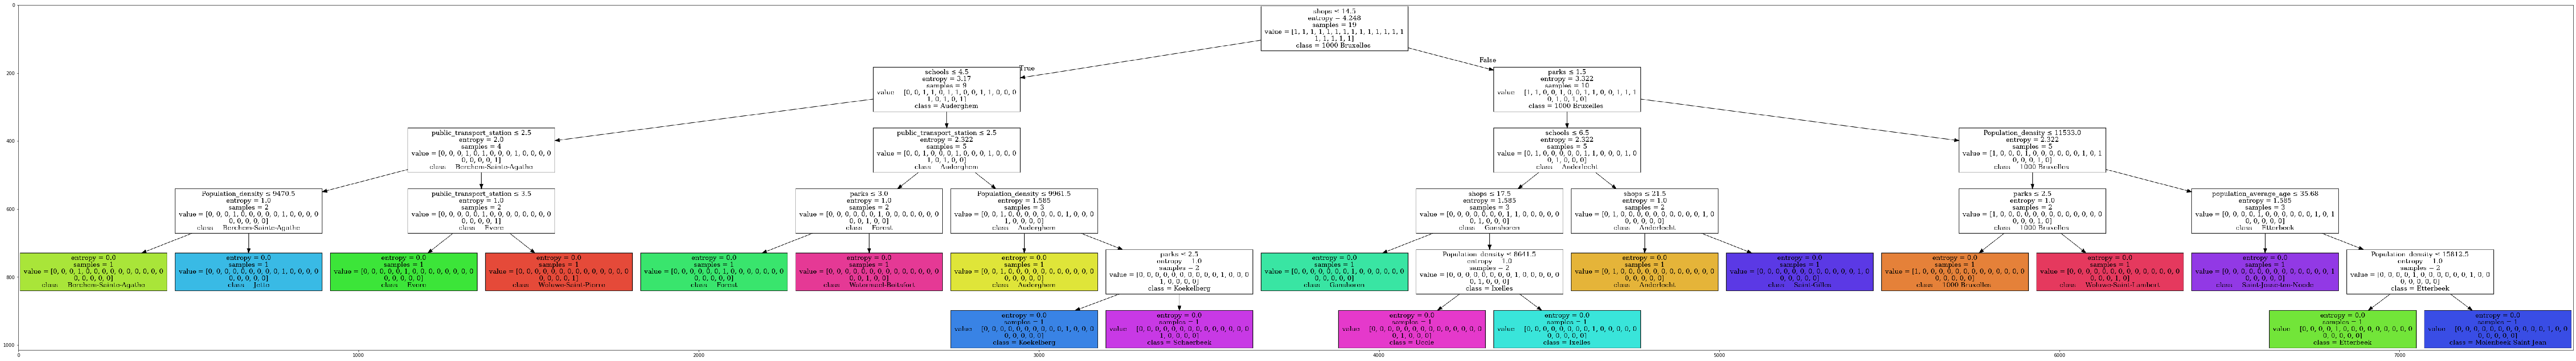

In [23]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline 

X = bxl_red[["Population_density", "population_average_age", "shops" , "schools", "public_transport_station" , "parks"]].values


y = bxl_red["Municipality"]

bxlTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

bxlTree.fit(X,y)


dot_data = StringIO()
filename = "bxl_mun_dens.png"
featureNames = bxl_red.columns[1:7]
targetNames = bxl_red["Municipality"].unique().tolist()
out=tree.export_graphviz(bxlTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [34]:
# Binning of count values

In [25]:
#create a new table to contain binned data
bxl_binned = bxl
bxl_binned.head()

,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks,restaurant-binned,schools-binned,pts-binned,shops-binned,parks-binned,density-binned
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,18,30,2,High,High,High,High,Low,Low
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,7,10,3,Medium,Medium,Medium,Low,Medium,Medium
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,8,30,2,High,Medium,Medium,High,Low,Medium
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,8,30,1,High,Medium,Medium,High,Low,Medium
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,2,28,0,High,High,Low,High,Low,High


In [19]:
# Population density 	restaurants 	schools 	metro_station 	shops 	parks

# define bin categories
group_names = ['Low', 'Medium', 'High']

#create the number of bins
bins_rest = np.linspace(min(bxl_binned["restaurants"]), max(bxl_binned["restaurants"]), 4)
# bins_rest

bins_schools = np.linspace(min(bxl_binned["schools"]), max(bxl_binned["schools"]), 4)
# bins_schools

bins_pts = np.linspace(min(bxl_binned["public_transport_station"]), max(bxl_binned["public_transport_station"]), 4)
# bins_metro

bins_shops = np.linspace(min(bxl_binned["shops"]), max(bxl_binned["shops"]), 4)
# bins_shops

bins_parks = np.linspace(min(bxl_binned["parks"]), max(bxl_binned["parks"]), 4)
# bins_parks

bins_density = np.linspace(min(bxl_binned["Population_density"]), max(bxl_binned["Population_density"]), 4)
# bins_density

#create binned fields

bxl_binned['restaurant-binned'] = pd.cut(bxl_binned['restaurants'], bins_rest, labels=group_names, include_lowest=True )
# bxl[['restaurants','restaurant-binned']].head(20)

bxl_binned['schools-binned'] = pd.cut(bxl_binned['schools'], bins_schools, labels=group_names, include_lowest=True )
# bxl[['schools','schools-binned']].head(20)

bxl_binned['pts-binned'] = pd.cut(bxl_binned['public_transport_station'], bins_pts, labels=group_names, include_lowest=True )
# bxl[['public_transport_station','pts-binned']].head(20)

bxl_binned['shops-binned'] = pd.cut(bxl_binned['shops'], bins_shops, labels=group_names, include_lowest=True )
# bxl[['shops','shops-binned']].head(20)

bxl_binned['parks-binned'] = pd.cut(bxl_binned['parks'], bins_parks, labels=group_names, include_lowest=True )
# bxl[['parks','parks-binned']].head(20)

bxl_binned['density-binned'] = pd.cut(bxl_binned['Population_density'], bins_density, labels=group_names, include_lowest=True )
# bxl[['parks','parks-binned']].head(20)
bxl_binned

,PostalCode,Municipality,Latitude,Longitude,size(km^2),population,Population_density,population_average_age,restaurants,schools,public_transport_station,shops,parks,restaurant-binned,schools-binned,pts-binned,shops-binned,parks-binned,density-binned
0,1000,1000 Bruxelles,50.846557,4.351697,32.61,179797,5514,41.86,30,10,18,30,2,High,High,High,High,Low,Low
1,1030,Schaerbeek,50.867604,4.373712,8.14,131547,16161,32.99,17,6,7,10,3,Medium,Medium,Medium,Low,Medium,Medium
2,1040,Etterbeek,50.836145,4.386174,3.15,48008,15241,35.75,25,6,8,30,2,High,Medium,Medium,High,Low,Medium
3,1050,Ixelles,50.833114,4.366828,6.34,86675,13671,40.95,30,6,8,30,1,High,Medium,Medium,High,Low,Medium
4,1060,Saint-Gilles,50.826741,4.345668,2.52,49715,19728,34.82,26,10,2,28,0,High,High,Low,High,Low,High
5,1070,Anderlecht,50.839098,4.329653,17.74,118920,6938,37.05,25,7,9,15,0,High,Medium,Medium,Medium,Low,Low
6,1080,Molenbeek-Saint-Jean,50.854596,4.338636,5.89,96501,16384,36.15,30,12,7,30,2,High,High,Medium,High,Low,Medium
7,1081,Koekelberg,50.860604,4.331550,1.17,21961,18770,38.80,9,6,6,7,2,Low,Medium,Low,Low,Low,High
8,1082,Berchem-Sainte-Agathe,50.864923,4.294673,2.95,25195,8541,39.05,2,2,1,8,0,Low,Low,Low,Low,Low,Low
9,1083,Ganshoren,50.870327,4.307798,2.64,24817,9400,37.89,5,3,0,16,0,Low,Low,Low,Medium,Low,Medium


In [20]:
bxl_binned = bxl_binned[['PostalCode', 'Municipality', 'restaurant-binned', 'schools-binned', 'pts-binned', 'shops-binned', 'parks-binned', 'density-binned']]
bxl_binned

,PostalCode,Municipality,restaurant-binned,schools-binned,pts-binned,shops-binned,parks-binned,density-binned
0,1000,1000 Bruxelles,High,High,High,High,Low,Low
1,1030,Schaerbeek,Medium,Medium,Medium,Low,Medium,Medium
2,1040,Etterbeek,High,Medium,Medium,High,Low,Medium
3,1050,Ixelles,High,Medium,Medium,High,Low,Medium
4,1060,Saint-Gilles,High,High,Low,High,Low,High
5,1070,Anderlecht,High,Medium,Medium,Medium,Low,Low
6,1080,Molenbeek-Saint-Jean,High,High,Medium,High,Low,Medium
7,1081,Koekelberg,Low,Medium,Low,Low,Low,High
8,1082,Berchem-Sainte-Agathe,Low,Low,Low,Low,Low,Low
9,1083,Ganshoren,Low,Low,Low,Medium,Low,Medium
